In [16]:
import os

HOME = os.getcwd()
DATA = os.path.join(HOME, 'training', 'layout-analysis', 'data', 'raw-data')

In [24]:
import cv2
import pytesseract
from pytesseract import Output

# Define a function to check if an image with text is rotated
def is_image_rotated(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use Tesseract to detect the orientation and script
    osd = pytesseract.image_to_osd(gray, output_type=Output.DICT)
    osd = pytesseract.image_to_string(gray, lang='rus')
    return osd
    
    # # Check if the image is rotated
    # rotation_angle = osd['rotate']
    # if rotation_angle != 0:
    #     return True, rotation_angle
    # else:
    #     return False, rotation_angle

# Example usage:
# rotated, angle = is_image_rotated('path_to_image.jpg')
# print(f"Is the image rotated? {rotated}, Rotation angle: {angle}")


In [34]:
for image_path in os.listdir(DATA):
    full_image_path = os.path.join(DATA, image_path)
    a = is_image_rotated(image_path=full_image_path)
    print(a)

    break

Противопоказания.

Повышенная чувствительйость к действующему веществу или к любому из
компонентов препарата.

Специфические инфекции в аноректальной области (туберкулез, сифилис,
гонорея), ветряная оспа, реакция на вакцинацию, грибковые заболевания,

воспалительные заболевания кожи лица (периоральный дерматит, розацеа),

другие бактериальные, вирусные, паразит ‚\[‚.Ё„ЁЗВЁН ые
ВАН

СОГЛАСО

Приказ Министерства здравоохранснмя 3
Рэаспублини Велаплуеть

Т ноА коожлПо!еМИНЫЦоННо «ботадаееке у -трна га жа омЫ ы ожллья та аат оЙ

поражения и атрофические изменения в област

средства, опухоли аНОРСКТЗЛЬНОЙ ЗОНЫ.

Меры предосторожности.

Лечение продолжать до исчезновения симптомов, но не более 5-7 дней.

При отсутствии эффекта необходимо пересмотреть проводимую терапию.
При применении любых глюкокортикостероидов следует помнить 0
возможности системной абсорбции.

В случае грибковых инфекций необходимо одновременно применять

местный противогрибковый препарат.

Взаимодействие с другими лекарс


0: 960x704 14.1ms
Speed: 5.6ms preprocess, 14.1ms inference, 5.0ms postprocess per image at shape (1, 3, 960, 704)


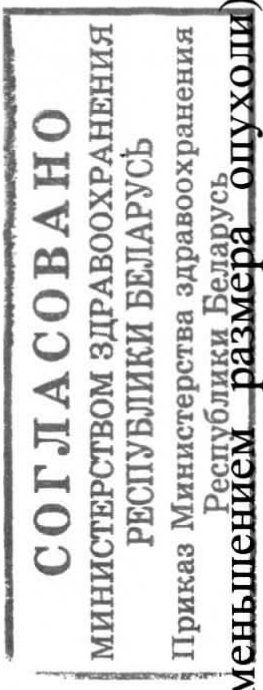

In [92]:
import os
from PIL import Image

import numpy as np

from modules.instructors import Instruction
from modules.detectors import YOLOStampDetector

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath


HOME = os.getcwd()

DATA_DIR = os.path.abspath(os.path.join(os.pardir, 'data'))
INSTR_DIR = os.path.join(DATA_DIR, 'instructions')
MODELS_DIR = os.path.join(HOME, "models")
YOLO_STAMP_DET_MODEL_PATH = os.path.join(MODELS_DIR, "yolo_stamp_detector.pt")

pdf_path = os.path.join(INSTR_DIR, '21_07_3165_i.pdf')
pdf_url = 'https://www.rceth.by/NDfiles/instr/21_07_3165_i.pdf'
instruction = Instruction(instr_dir=INSTR_DIR,
                            pdf_url=pdf_url)  # , pdf_path=pdf_path)

image = instruction.instr_imgs[2]

# YOLO
yolo_detector = YOLOStampDetector(model_path=YOLO_STAMP_DET_MODEL_PATH,
                                    model_type='n')
results = yolo_detector.predict(image)
crops = yolo_detector.crop_keys(image=image,
                                results=results)
cropped_table = Image.fromarray(crops[0])
cropped_table

In [93]:
bbox = results[0].obb.xyxyxyxy.detach().cpu().numpy()
bbox

array([[[     1610.4,      20.973],
        [     1610.7,      284.24],
        [     2301.5,      283.44],
        [     2301.2,      20.168]]], dtype=float32)

In [94]:
img = np.array(image)
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [95]:
def apply_convertScaleAbs_to_roi(image, bbox, alpha=3, beta=0):
    bbox = bbox.astype(np.int32)
    # Create a mask for the bounding box region
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, bbox, (255, 255, 255))

    # Extract the region of interest (ROI) from the image
    roi = cv2.bitwise_and(image, mask)

    # Apply cv2.convertScaleAbs to the ROI
    converted_roi = cv2.convertScaleAbs(roi, alpha=alpha, beta=beta)

    # Update the original image with the processed ROI
    result = np.where(mask == 255, converted_roi, image)

    return result

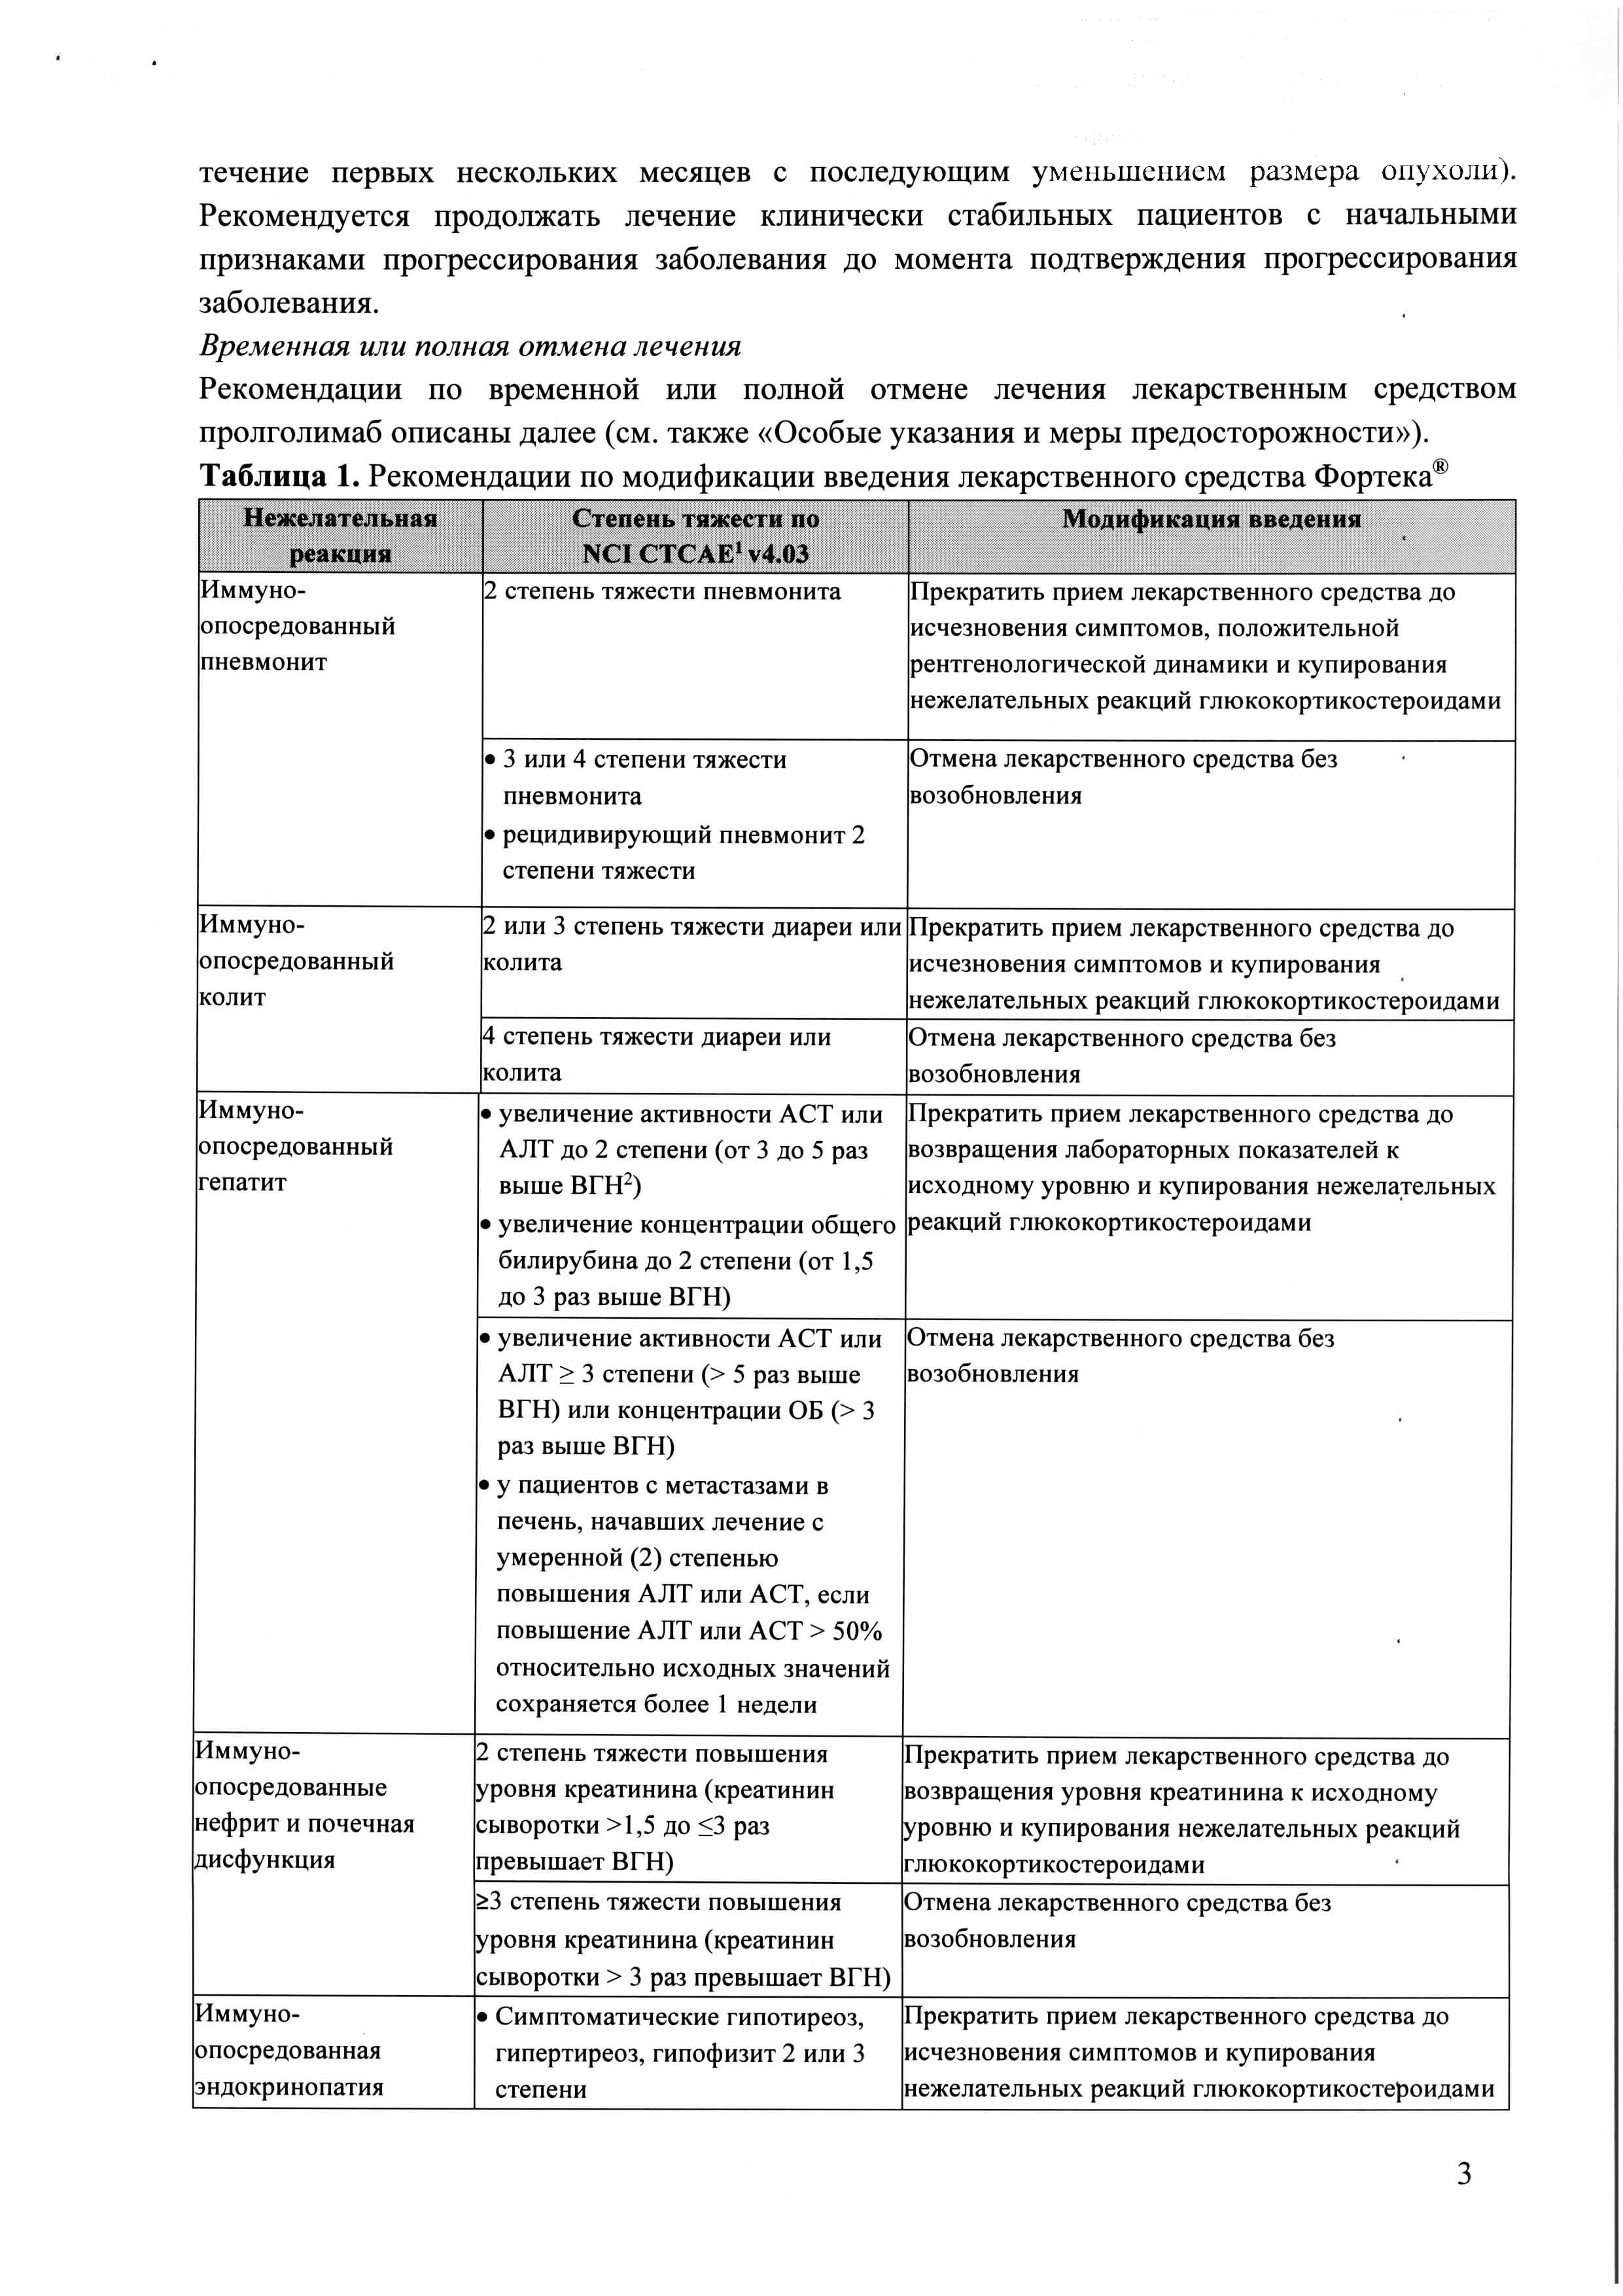

In [96]:
adj = apply_convertScaleAbs_to_roi(image=img, bbox=bbox)
Image.fromarray(adj)